In [1]:
import sys
sys.path.append('../Codes/')
import numpy as np
import matplotlib.pyplot as plt
from Immuno_models import*
from Bio import Phylo
from io import StringIO
from matplotlib.lines import Line2D
from datetime import datetime, timedelta
import scipy.special as sc
import os.path
import pickle
from matplotlib import style
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

def linear_func(x, a, b):
    return a + b*x

N_A = 6.02214076e23
k_BT = 1.380649e-23*293
style.use('seaborn-paper')
print(style.available)
%autosave 60

['seaborn-dark', 'seaborn-darkgrid', 'seaborn-ticks', 'fivethirtyeight', 'seaborn-whitegrid', 'classic', '_classic_test', 'fast', 'seaborn-talk', 'seaborn-dark-palette', 'seaborn-bright', 'seaborn-pastel', 'grayscale', 'seaborn-notebook', 'ggplot', 'seaborn-colorblind', 'seaborn-muted', 'seaborn', 'Solarize_Light2', 'seaborn-paper', 'bmh', 'tableau-colorblind10', 'seaborn-white', 'dark_background', 'seaborn-poster', 'seaborn-deep']


Autosaving every 60 seconds


## Generating Sequences

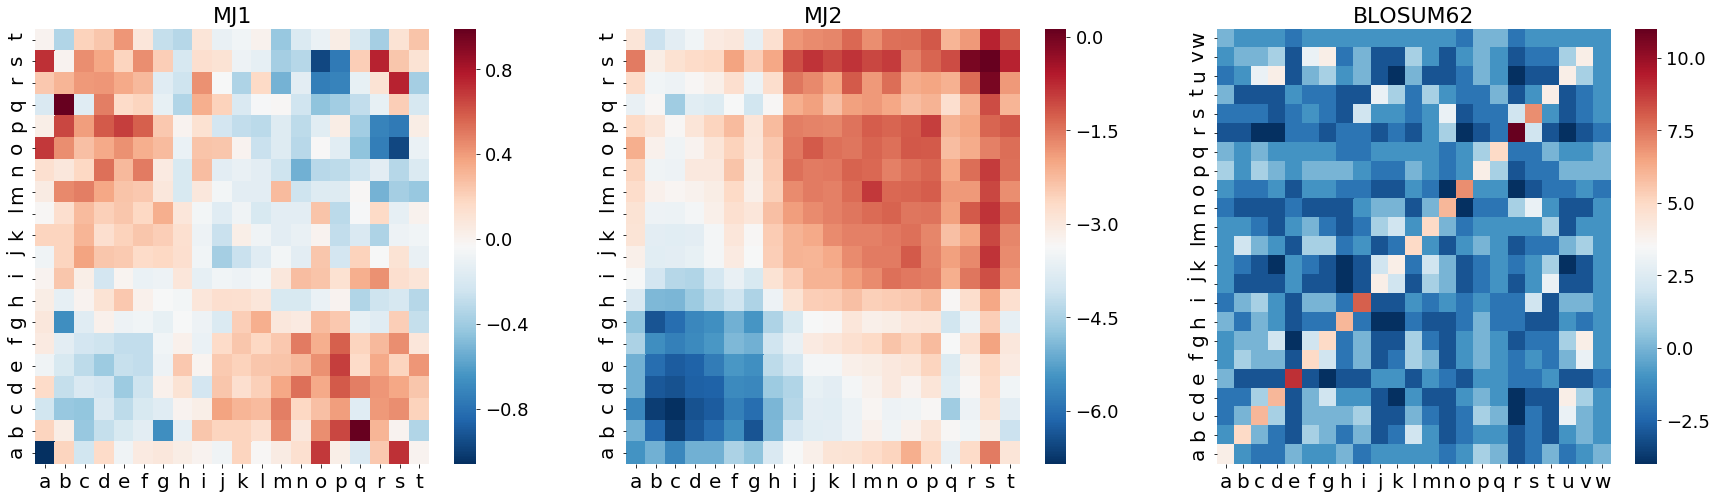

In [2]:
M1 = np.loadtxt('../Text_files/MJ.txt', skiprows= 1, usecols=range(1,21)).tolist()
M2 = (np.loadtxt('../Text_files/MJ2.txt', skiprows= 1, usecols=range(1,21))).tolist()
M3 = np.loadtxt('../Text_files/BLOSUM62.txt', skiprows= 1, max_rows = 23, usecols=range(1,24)).tolist()
Alphabet = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't']
Alphabet2 = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w']

fig, ax = plt.subplots(1,3,figsize=(30,8))

plot_energy_matrix(Energy_Matrix = M1, Alphabet = Alphabet, title = 'MJ1', ax = ax[0])
plot_energy_matrix(Energy_Matrix = M2, Alphabet = Alphabet, title = 'MJ2', ax = ax[1])
plot_energy_matrix(Energy_Matrix = M3, Alphabet = Alphabet2, title = 'BLOSUM62', ax = ax[2])

fig.savefig('../Figures/Energy_matrices.png')

In [2]:
%%time
n_seq = 400000

#Sequences = generate_Sequences(n_seq, Energy_Matrix = )
#pickle.dump( Sequences, open( "../Text_files/Sequences-n_seq-%d.pkl"%(n_seq), "wb" ) )

Sequences = pickle.load( open( "../Text_files/Sequences-n_seq-%d.pkl"%(n_seq), "rb" ) )

#print_raw_file(Sequences, "../Text_files/file2.txt")
#generate_newick_format("../Text_files/file2.txt")


CPU times: user 2.57 s, sys: 263 ms, total: 2.83 s
Wall time: 2.84 s


In [3]:
Sequences[8000].master_sequence, Sequences[8000].sequence, Sequences[8000].hamming_distance, Sequences[8000].energy_parent, Sequences[8000].energy, Sequences[8000].delta_energy, Sequences[0].energy

('odsadmgao',
 'mdnbdmgat',
 4,
 -3.1000000000000014,
 -3.1200000000000014,
 -0.01999999999999999,
 -5.500000000000001)

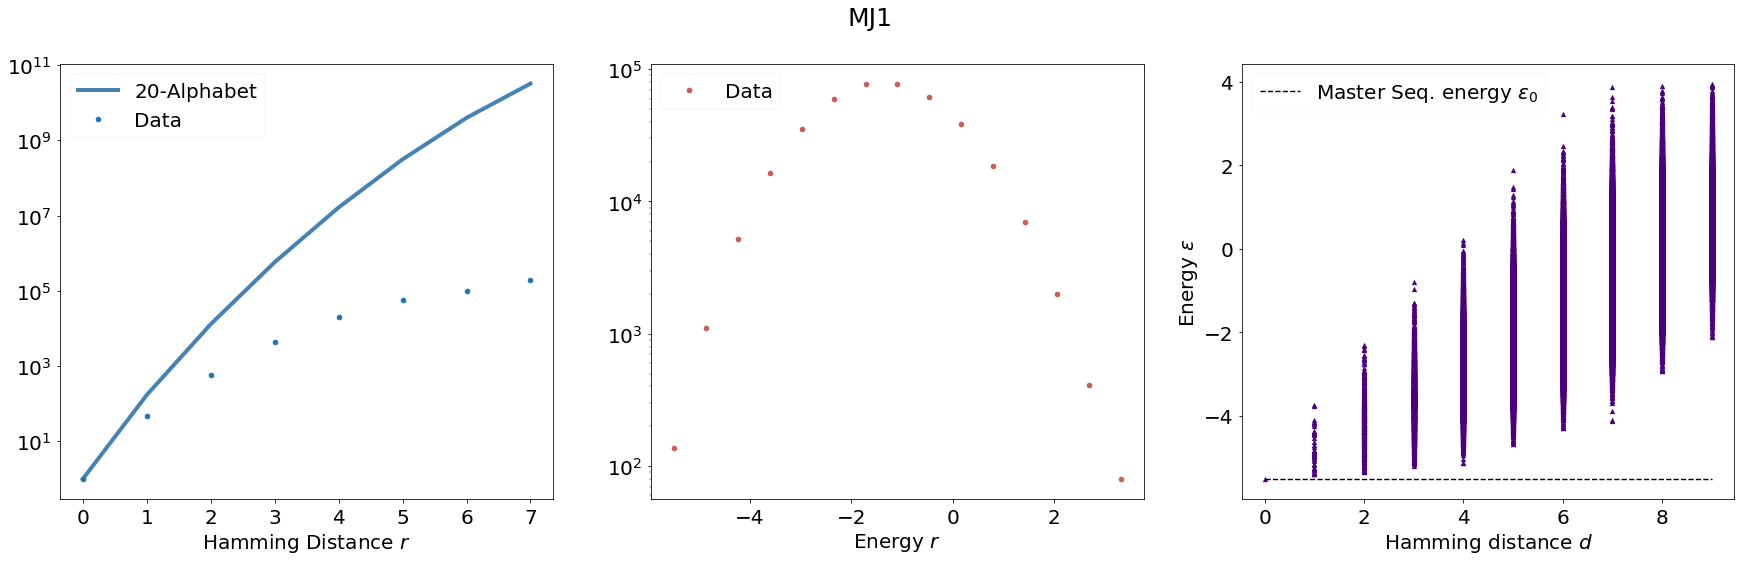

In [6]:
fig, ax = plt.subplots(1,3,figsize=(30,8))
fig.suptitle('MJ1', fontsize = 25)
distances = plot_histogram_hamming_distance(Sequences = Sequences, ax = ax[0])
energies = plot_histogram_energy(Sequences = Sequences, bins = 15, ax = ax[1])
plot_scatter_hamming_distance_energy(distances = distances, energies = energies, ax = ax[2])

fig.savefig('../Figures/Sequences_MJ1-n_seq-%d.png'%(n_seq))


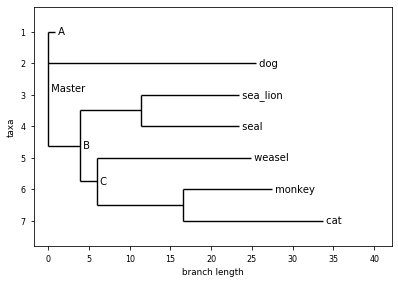

In [21]:
tree = Phylo.read(StringIO("Master(A():0.84600,B((sea_lion:11.99700, seal:12.00300):7.52973,C((monkey:10.85930,cat:17.14069):10.59201, weasel:18.87953):2.09460):3.87382,dog:25.46154):0"), "newick")
tree.ladderize()  # Flip branches so deeper clades are displayed at top
Phylo.draw(tree)

# Ensemble of systems

## Distribution of linage sizes

In [4]:
%%time
run_ensemble_linage_size_distribution(Sequences = Sequences, n_linages = 200, n_seq = 400000, nu = 0.4, beta = 1,
                                     T = 5, master_Sequence_energy = 14, n_sim = 5, new = False)


0 ...
1 ...
2 ...
3 ...
4 ...
Ensemble size: 72270


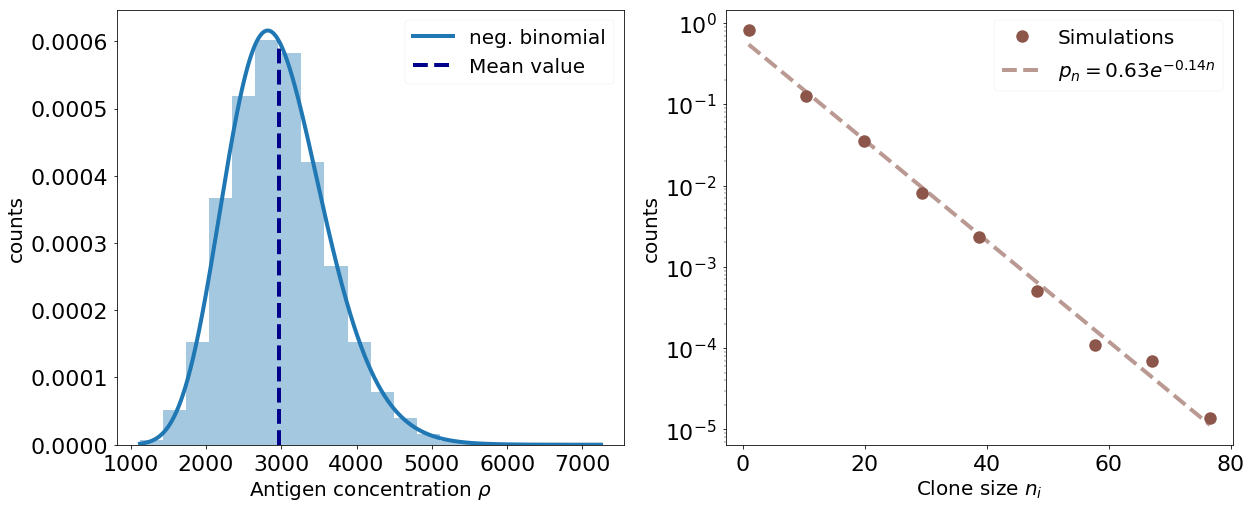

In [308]:
fig, ax = plt.subplots(1, 2, figsize = (20,8))

#_______________________________________________________________________________________________________________

final_antigen_concentration = pickle.load( open( "../Text_files/final_antigen_concentration.pkl", "rb" ) )

x = np.array(range(int(min(final_antigen_concentration)) , int(max(final_antigen_concentration))))
p = np.exp(-1*5)
n_array = np.array(range(1,80))

ax[0].hist(final_antigen_concentration, bins = 20, density = True, alpha = 0.4)
ax[0].plot(x, sc.comb(x-1, x-20)*p**(20)*(1-p)**(x-20), color = 'tab:blue', linewidth = 4, ms=8, label='neg. binomial')
ax[0].vlines(20*np.exp(5), 0, sc.comb(20*np.exp(5)-1, 20*np.exp(5)-20)*p**(20)*(1-p)**(20*np.exp(5)-20), linestyle = 'dashed', linewidth = 4, color = 'darkblue', label = 'Mean value')
ax[0].set_xlabel(r'Antigen concentration $\rho$', fontsize = 20)
ax[0].set_ylabel(r'counts', fontsize = 20)
ax[0].tick_params(labelsize = 22)
ax[0].legend(loc = 0, fontsize = 20)
#_______________________________________________________________________________________________________________

activated_linages_size_t = pickle.load( open( "../Text_files/activated_linages_size_t.pkl", "rb" ) )

#data_activated_linages2 = np.histogram(activated_linages_size_t, bins = np.logspace(1,np.log10(np.max(activated_linages_size_t)),10))
data_activated_linages2 = np.histogram(activated_linages_size_t, bins = np.linspace(1,np.max(activated_linages_size_t),10))

#Cumulative
#ax[1].plot(data_activated_linages[1][:-1], 1-np.cumsum(data_activated_linages[0])/np.sum(data_activated_linages[0]), marker = '.', ms = 20, linestyle = '', linewidth = 4, color = 'tab:red')
#ax[1].plot(data_activated_linages[1][:-1], (data_activated_linages[0][0]/np.sum(data_activated_linages[0]))*(data_activated_linages[1][:-1])**(-1), linestyle = '--', color = 'tab:red', label = r'$p\sim n_i^{-1}$')

#Distribution
#ax[1].plot(data_activated_linages[1][:-1], data_activated_linages[0]/np.sum(data_activated_linages[0]), marker = '.', ms = 20, linestyle = '', linewidth = 4, color = 'tab:brown', label = 'Simulations')
ax[1].plot(data_activated_linages2[1][:-1], data_activated_linages2[0]/np.sum(data_activated_linages2[0]), marker = '.', ms = 25, linestyle = '', linewidth = 4, color = 'tab:brown', label = 'Simulations')
#ax[1].plot(data_activated_linages2[1][:-1], 1-np.cumsum(data_activated_linages2[0]/np.sum(data_activated_linages2[0])), marker = '.', ms = 25, linestyle = '', linewidth = 4, color = 'tab:brown', label = 'Simulations')

#ax[1].plot(data_activated_linages[1][:-1], 100*4.5*np.exp(5.5-12)*((data_activated_linages[1][:-1]))**(-2), linestyle = '--', color = 'tab:brown', label = r'$p\sim n_i^{-2}$')
#ax[1].plot(data_activated_linages[1][:-1], 100000*4.5*np.exp(5.5-12)*((data_activated_linages[1][:-1]))**(-2), linestyle = '--', color = 'tab:brown')

popt, pcov = curve_fit(linear_func, data_activated_linages2[1][:-1], np.log(data_activated_linages2[0]/np.sum(data_activated_linages2[0])), p0 = (0, -5/40))

ax[1].plot(data_activated_linages2[1][:-1], np.exp(linear_func(data_activated_linages2[1][:-1], *popt)), linestyle = '--', linewidth = 4, color = 'tab:brown', alpha = 0.6, label = r'$p_n= %.2fe^{%.2fn}$'%(np.exp(popt[0]), popt[1]))
#ax[1].plot(n_array, 20*b*n_array**(-1/nu)*np.exp(5), linestyle = '--', linewidth = 4, color = 'tab:brown', alpha = 0.6, label = r'$p_n= %.2fe^{%.2fn}$'%(np.exp(popt[0]), popt[1]))
#ax[1].plot(n_array, 1+20*b*(1/nu)*n_array**(-(1+nu)/nu)*np.exp(5), linestyle = '--', linewidth = 4, color = 'tab:brown', alpha = 0.6, label = r'$p_n= %.2fe^{%.2fn}$'%(np.exp(popt[0]), popt[1]))

ax[1].set_xlabel(r'Clone size $n_i$', fontsize = 20)
ax[1].set_ylabel(r'counts', fontsize = 20)
ax[1].tick_params(labelsize = 22)
#ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].legend(loc = 0, fontsize = 20)

#_______________________________________________________________________________________________________________

counter = 0
while(os.path.isfile('../Figures/Linages_size_distribution_%d.png'%(counter))):
    counter+=1
    
#fig.savefig('../Figures/Linages_size_distribution_%d.png'%(counter))
#plt.close()


## Activation rate

In [77]:
%%time
n_linages = 200
U = n_linages/n_seq
nu = 0.4
R=6
beta = 1
gamma = 1
T = 5
master_Sequence_energy = 14

activation_time_series_rho = np.zeros(40)
activation_time_series_rho_2 = np.zeros(40)
activation_time_series_t = np.zeros(40)
range_energy = 0
min_energy = 0
max_rho = 1.2e3
rho_new = np.linspace(20, max_rho, 40)
t_new = np.linspace(0, 5, 40)

counter = 1000
for i in range(counter):
    if(i%100==0):
        print(i, '...')
    Sub_Sequences = np.random.choice(Sequences, n_linages)
    sub_energies = np.array([i.energy for i in Sub_Sequences])
    range_energy += (np.max(sub_energies) - np.min(sub_energies))
    min_energy += np.min(sub_energies)
    
    Model = Stochastic_simulation(Sequences = Sub_Sequences, n_linages=n_linages, T = T, U = U, gamma = gamma,
                                  nu = nu, R = R, beta = beta, master_Sequence_energy = master_Sequence_energy)
    Model.Gillespie()

    activation_time_series_i = [np.sum(Model.activation_time_series[:,i]) for i in range(int(len(Model.activation_time_series[0,:])))]
    f_rho = interp1d(Model.antigen_time_series, activation_time_series_i)
    f_t = interp1d(Model.time_series, activation_time_series_i)
    activation_time_series_rho = activation_time_series_rho + f_rho(rho_new)
    activation_time_series_rho_2 = activation_time_series_rho_2 + (f_rho(rho_new))**2
    activation_time_series_t = activation_time_series_t + f_t(t_new)

        
activation_time_series_rho = activation_time_series_rho/(counter)
activation_time_series_rho_2 = (activation_time_series_rho_2)/(counter)
activation_time_series_rho_var = activation_time_series_rho_2-activation_time_series_rho**2
activation_time_series_t = activation_time_series_t/(counter)
range_energy = range_energy/(counter)
min_energy = min_energy/(counter)

print(range_energy, min_energy)

pickle.dump(activation_time_series_rho, open( "../Text_files/activation_time_series_rho.pkl", "wb" ) )
pickle.dump(activation_time_series_rho_var, open( "../Text_files/activation_time_series_rho_var.pkl", "wb" ) )
pickle.dump(activation_time_series_t, open( "../Text_files/activation_time_series_t.pkl", "wb" ) )


0 ...


/Users/robertomorantovar/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:610: RuntimeWarning: invalid value encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


100 ...
200 ...
300 ...
400 ...
500 ...
600 ...
700 ...
800 ...
900 ...
6.6269800000000005 -4.247470000000003
CPU times: user 2h 52min 43s, sys: 1h 6min 25s, total: 3h 59min 9s
Wall time: 4h 1min 32s



-2.248872023602036 0.5511649370311624
-0.01983490360679615 0.0007902451447128282
0.000863868628606757


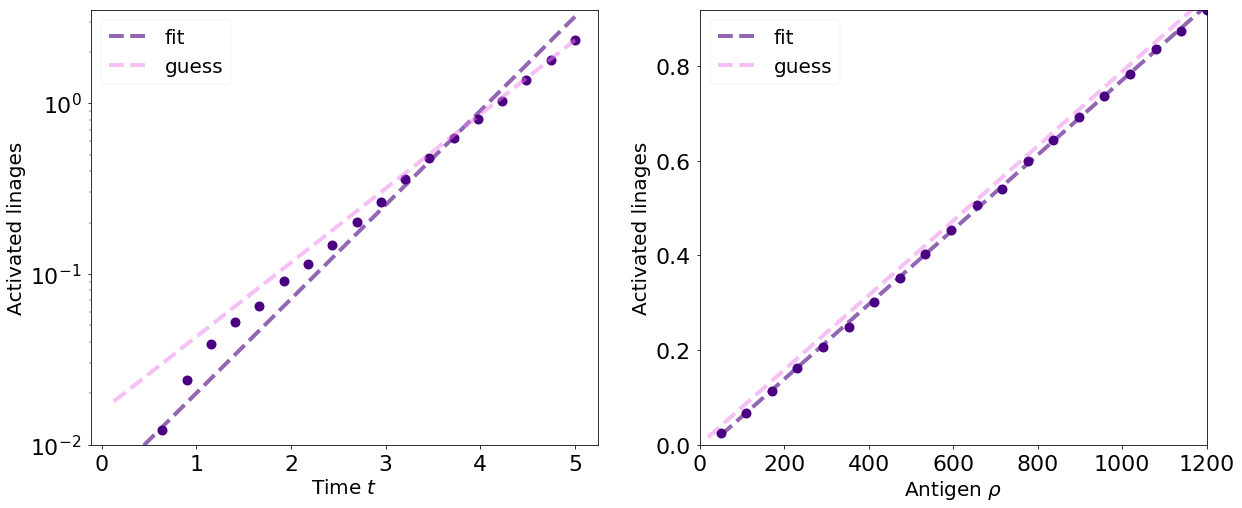

In [276]:
fig, ax = plt.subplots(1,2,figsize=(20,8))
gamma = 1
R_0 = 12
b = 100*np.exp(-14+1.5+3/4)
print()
#________________________________________________________________________________________

t_new = np.linspace(0, 5, 40)
activation_time_series_t = pickle.load( open( "../Text_files/activation_time_series_t.pkl", "rb" ) )
popt, pcov = curve_fit(linear_func, t_new[1:], np.log10(activation_time_series_t[1:]))
ax[0].plot(t_new[1:][::2], activation_time_series_t[1:][::2], '.', ms = 20, linewidth = 4, color = 'indigo')
ax[0].plot(t_new[1:], 10**linear_func(t_new[1:], *popt), '--', ms = 20, linewidth = 4, color = 'indigo', alpha = 0.6, label = 'fit')
activation_time_series_i = [np.sum(Model.activation_time_series[:,i]) for i in range(int(len(Model.activation_time_series[0,:])))]
ax[0].plot(t_new[1:], 20*b*np.exp(t_new[1:]), '--', color = 'violet', alpha = 0.5, linewidth = 4, label ='guess')
#ax[0].plot(Model.time_series, activation_time_series_i, color = 'indigo', alpha = 0.3)
print(*popt)
ax[0].set_xlabel(r'Time $t$', fontsize = 20)
ax[0].set_ylabel(r'Activated linages', fontsize = 20)
ax[0].tick_params(labelsize = 22)
#ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_ylim(0.01, max(activation_time_series_t[1:]*1.5))
ax[0].legend(loc = 0, fontsize = 20)

#________________________________________________________________________________________

rho_new = np.linspace(20, max_rho, 40)
activation_time_series_rho = pickle.load( open( "../Text_files/activation_time_series_rho.pkl", "rb" ) )
activation_time_series_rho_var = pickle.load( open( "../Text_files/activation_time_series_rho_var.pkl", "rb" ) )

popt, pcov = curve_fit(linear_func, rho_new[1:], activation_time_series_rho[1:])

ax[1].plot(rho_new[1:][::2], activation_time_series_rho[1:][::2], '.', ms = 20, linewidth = 4, color = 'indigo')
ax[1].plot(rho_new[1:], linear_func(rho_new[1:], *popt), '--', ms = 20, linewidth = 4, color = 'indigo', alpha = 0.6, label ='fit')
#ax[1].plot(Model.antigen_time_series, activation_time_series_i, color = 'violet', alpha = 0.3)
#ax[1].plot(rho_new, linear_func(rho_new, 0, np.exp(5-14)*6.6 ), '--', color = 'violet', alpha = 0.5, linewidth = 4, label ='guess')
ax[1].plot(rho_new, linear_func(rho_new, 0, b), '--', color = 'violet', alpha = 0.5, linewidth = 4, label ='guess')

print(*popt)
#ax[1].fill_between(rho_new, activation_time_series_rho-np.sqrt(activation_time_series_rho_var), activation_time_series_rho + np.sqrt(activation_time_series_rho_var), color='indigo', alpha = 0.3)
#ax[1].plot(rho_new, (1/gamma)*(rho_new*np.exp(-12-(-5))-1))
#ax[1].plot(rho_new, 4.4*(rho_new*np.exp(-12-(-5.5))))
ax[1].set_xlabel(r'Antigen $\rho$', fontsize = 20)
ax[1].set_ylabel(r'Activated linages', fontsize = 20)
ax[1].tick_params(labelsize = 22)
#ax[1].set_xscale('log')
#ax[1].set_yscale('log')
ax[1].set_xlim(0,max_rho)
ax[1].set_ylim(0,np.max(activation_time_series_rho[1:]))
ax[1].legend(loc = 0, fontsize = 20)

#________________________________________________________________________________________

counter = 0
while(os.path.isfile('../Figures/Activation_rate_%d.png'%(counter))):
    counter+=1
    
#fig.savefig('../Figures/Activation_rate_%d.png'%(counter))
#plt.close()
print(np.exp(5-14)*7)

(1, 200000.0)

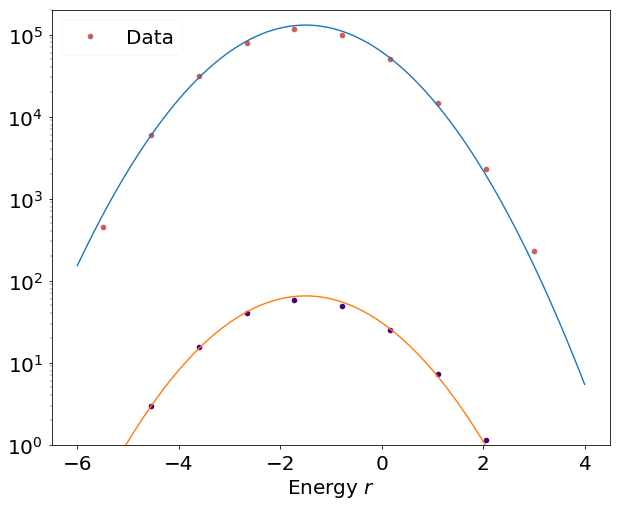

In [309]:
fig, ax = plt.subplots(1,1, figsize = (10, 8))
#___________________________________________
energies = plot_histogram_energy(Sequences = Sequences, bins = 10, ax = ax)
r_array = np.linspace(np.min(energies), np.min(energies)+5, 100)
r_array_2 = np.linspace(-6, 4, 100)
sigma = 3
ax.plot(r_array_2, (4e5/(np.sqrt(np.pi*sigma)))*np.exp(-(1/sigma)*(r_array_2+1.5)**2))
#ax.plot(r_array, 1*np.exp(7*(r_array+5.5)))
#___________________________________________
#sub_energies = np.array([])
#for i in range(5000):
#   Sub_Sequences = np.random.choice(Sequences, n_linages)
#    sub_energies = np.append(sub_energies,np.array([i.energy for i in Sub_Sequences]))
data_energies = np.histogram(sub_energies, bins=10)
ax.plot(data_energies[1][0:-1], data_energies[0]/(5000), linewidth = 4, color = 'indigo', label = 'Data', linestyle = '', marker = 'o')
#ax.plot(r_array, np.exp(1*(r_array+4)))
ax.plot(r_array_2, (200/(np.sqrt(np.pi*sigma)))*np.exp(-(1/sigma)*(r_array_2+1.5)**2))
#___________________________________________   
#ax.set_xlim(np.min(energies)-0.1, np.min(energies)+2)
#ax.set_yscale('linear')
ax.set_ylim(1, 2e5)

## Detection time

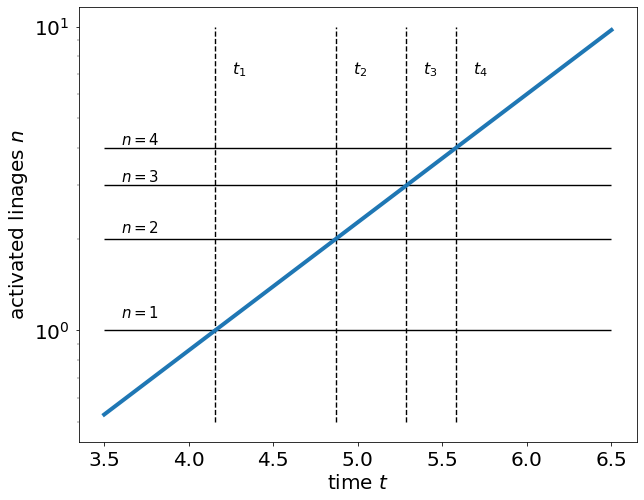

In [185]:
fig, ax = plt.subplots(1,1, figsize=(10,8))

t = np.linspace(3.5, 6.5, 50)
N_b = 10**(-1.7530906647767526)*10**(0.4218331847047946*t)

ax.plot(t, N_b, linewidth = 4)

ax.hlines([1, 2, 3, 4], 3.5, 6.5)
ax.vlines(np.log10(np.array([1,2,3,4])/(10**(-1.7530906647767526)))/(0.4218331847047946), .5, 10, linestyle = 'dashed')

ax.text(3.6,1.1, r'$n = 1$', fontsize = 15)
ax.text(3.6,2.1, r'$n = 2$', fontsize = 15)
ax.text(3.6,3.1, r'$n = 3$', fontsize = 15)
ax.text(3.6,4.1, r'$n = 4$', fontsize = 15)

ax.text(np.log10(np.array([1])/(10**(-1.7530906647767526)))/(0.4218331847047946) + .1 ,7, r'$t_1$', fontsize = 16)
ax.text(np.log10(np.array([2])/(10**(-1.7530906647767526)))/(0.4218331847047946) + .1 ,7, r'$t_2$', fontsize = 16)
ax.text(np.log10(np.array([3])/(10**(-1.7530906647767526)))/(0.4218331847047946) + .1 ,7, r'$t_3$', fontsize = 16)
ax.text(np.log10(np.array([4])/(10**(-1.7530906647767526)))/(0.4218331847047946) + .1 ,7, r'$t_4$', fontsize = 16)

#ax.text(0, 20, r'$t_n \approx \ln{\left(\frac{n}{UR}\right)} + R_0$', fontsize = 25)
ax.set_xlabel(r'time $t$', fontsize = 20)
ax.set_ylabel(r'activated linages $n$', fontsize = 20)
ax.set_yscale('log')
ax.tick_params(labelsize = 20)
#ax.legend(fontsize = 20)
fig.savefig('../Figures/Activation_times.png')


In [8]:
Sequences2 = pickle.load( open( "../Text_files/Sequences-n_seq-%d.pkl"%(100), "rb" ) )

fig, ax = plt.subplots(1,3,figsize=(30,8))

distances = plot_histogram_hamming_distance(Sequences = Sequences2, ax = ax[0])
energies = plot_histogram_energy(Sequences = Sequences2, bins = 100, ax = ax[1])
plot_scatter_hamming_distance_energy(distances = distances, energies = energies, ax = ax[2])

fig.savefig('../Figures/Sequences-n_seq-%d.png'%(100))
plt.close()


In [46]:
1/(1+np.exp(Sequences[200000].energy+3)), Sequences[200000].hamming_distance

(0.3143198860617463, 6)